In [111]:
%matplotlib widget
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import so101
from math_utils import hat_twist, unhat_twist, transformation_adjoint, tangent_space_error, transformation_matrix


Generate the Path that we want to follow

In [ ]:
# Basic parameters
# increasing the number of points makes it more accurate however I am leaving it course for demonstration purposes
num_points_target = 25
# Interpolating in between IK points to see how the continuous function behaves
joint_space_interpolation_factor = 100

In [ ]:
# Straight line path in task space
start_point = np.array([0.05, -0.05, 0.05])
end_point = np.array([0.05, 0.05, 0.05])
rotation = np.array([
    [0, 1, 0],
    [0, 0, -1],
    [-1, 0, 0]
])
displacements = np.linspace(start_point, end_point, num_points_target)
task_space_path = [transformation_matrix(rotation, disp) for disp in displacements]

displacements_interpolated = np.linspace(start_point, end_point, ((num_points_target-1) * joint_space_interpolation_factor + 1))
task_space_path_interpolated = [transformation_matrix(rotation, disp) for disp in displacements_interpolated]

Joint space calculations

In [114]:
def joint_space_trajectory_interpolation(joint_space_path, factor):
    interpolated_path = []
    for i in range(len(joint_space_path) - 1):
        start_angles = joint_space_path[i]
        end_angles = joint_space_path[i + 1]
        for t in np.linspace(0, 1, factor, endpoint=False):
            interp_angles = (1 - t) * start_angles + t * end_angles
            interpolated_path.append(interp_angles)
    interpolated_path.append(joint_space_path[-1])  # Append the last point
    return interpolated_path

In [ ]:
def plot_trajectories(joint_space_path, end_effector_path, displacements, method):
    # Plot joint angles and end-effector trajectory side-by-side
    joint_space_path = np.array(joint_space_path)
    end_effector_path = np.array(end_effector_path)

    fig = plt.figure(figsize=(12, 5))

    # Left subplot: joint angles over time
    ax1 = fig.add_subplot(1, 2, 1)
    for i in range(joint_space_path.shape[1]):
        ax1.plot(joint_space_path[:, i], label=f'Joint {i+1}')
    ax1.set_title('Joint Angles over Time (Inverse Kinematics)')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Joint Angle (radians)')
    ax1.legend()
    ax1.grid(True)

    # Right subplot: 3D target vs end-effector trajectory
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot(displacements[:, 0], displacements[:, 1], displacements[:, 2], label='Target Trajectory', color='r')
    ax2.plot(end_effector_path[:, 0], end_effector_path[:, 1], end_effector_path[:, 2], label='End-Effector Trajectory (IK)', color='b')
    ax2.set_title(f'End-Effector Trajectory vs Target Trajectory ({method})')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.legend()
    # Set axes limits to -1..1 for consistent scale
    ax2.set_xlim([0.04, 0.06])
    ax2.set_ylim([-0.1, 0.1])
    ax2.set_zlim([0.04, 0.06])
    # Try to enforce equal aspect ratio (requires matplotlib >= 3.3). If unavailable, ignore the error
    plt.tight_layout()
    plt.show()

starting with the inverse kinematics

In [ ]:
joint_space_path_ik = []
joint_angles = None
for g_target in task_space_path:
    joint_angles = so101.SO101._inverse_kinematics(g_target, joint_angles)
    joint_space_path_ik.append(joint_angles)

joint_space_path_ik = joint_space_trajectory_interpolation(joint_space_path_ik, joint_space_interpolation_factor)
end_effector_path_ik = []
for joint_angles in joint_space_path_ik:
    gwe = so101.SO101._forward_kinematics(joint_angles)
    end_effector_path_ik.append(gwe[:3, 3])

================= Inverse Kinematics Result ================
IK computation time: 0.0324 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 2.2194673112137136e-11
================= Inverse Kinematics Result ================
IK computation time: 0.0214 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 3.7197250990929035e-11
================= Inverse Kinematics Result ================
IK computation time: 0.0213 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 3.876626672827686e-12
================= Inverse Kinematics Result ================
IK computation time: 0.0210 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 2.6192549581140127e-11
================= Inverse Kinematics Result ================
IK computation time: 0.0237 seconds
IK optimization success: Tru

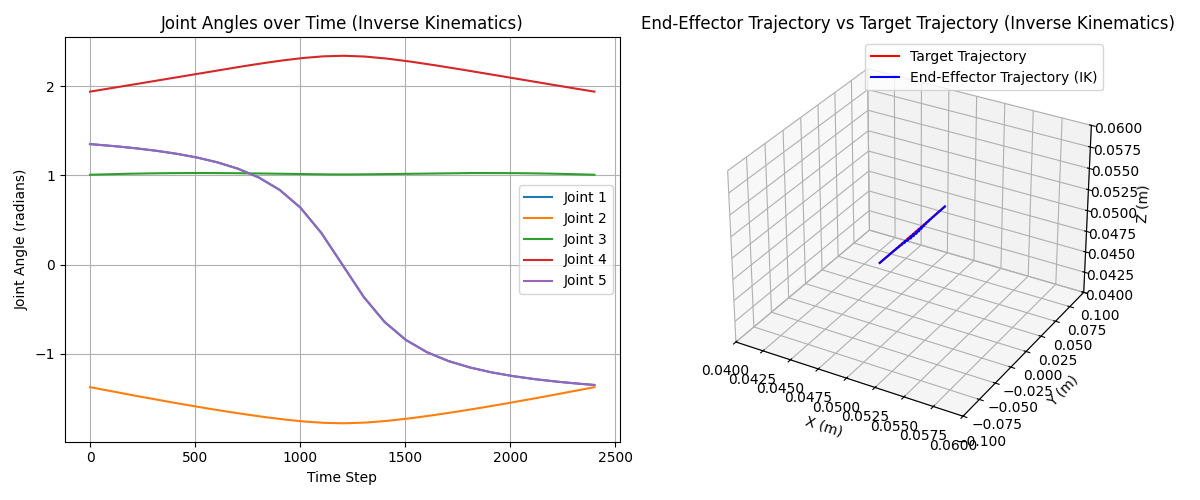

In [ ]:
plot_trajectories(joint_space_path_ik, end_effector_path_ik, displacements, "Inverse Kinematics")

Resolved Rate


In [ ]:
joint_space_path_rr = np.zeros((len(task_space_path), so101.SO101.num_joints))
joint_space_path_rr[0] = so101.SO101._inverse_kinematics(task_space_path[0])

for i in range(1, len(task_space_path)):
    gwe = task_space_path[i - 1]
    g_w_ep1 = task_space_path[i]
    g_e_ep1 = np.linalg.inv(gwe) @ g_w_ep1
    twist = unhat_twist(sp.linalg.logm(g_e_ep1))
    Jb = so101.SO101._body_jacobian(joint_space_path_rr[i - 1])
    Jb_dagger = np.linalg.pinv(Jb)
    joint_space_path_rr[i] = joint_space_path_rr[i - 1] + Jb_dagger @ twist

joint_space_path_rr = joint_space_trajectory_interpolation(joint_space_path_rr, joint_space_interpolation_factor)
end_effector_path_rr = []
for joint_angles in joint_space_path_rr:
    gwe = so101.SO101._forward_kinematics(joint_angles)
    end_effector_path_rr.append(gwe[:3, 3])

================= Inverse Kinematics Result ================
IK computation time: 0.0481 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 2.2194673112137136e-11


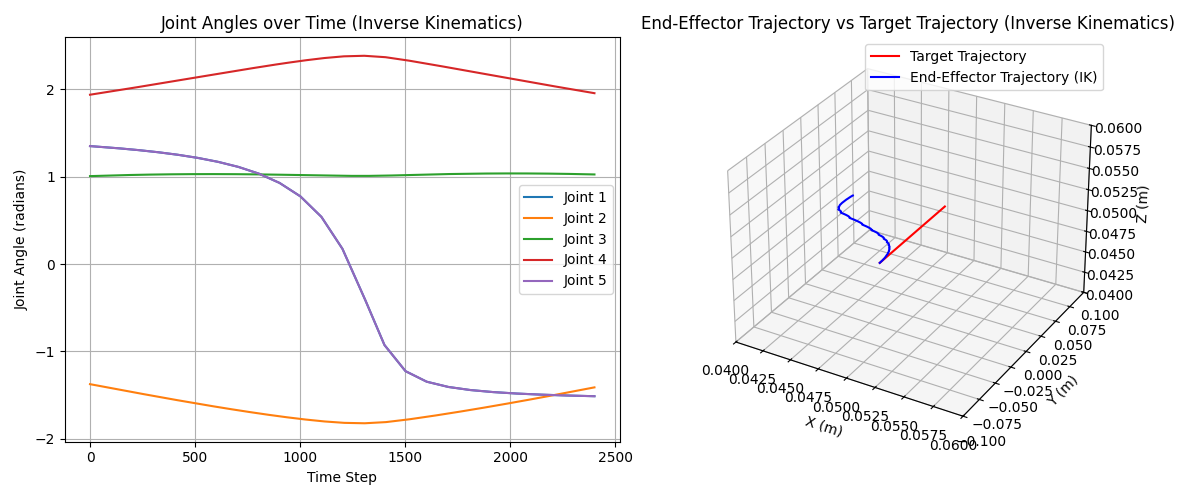

In [ ]:
plot_trajectories(joint_space_path_rr, end_effector_path_rr, displacements, "Resolved Rates")

"Closed Loop" Resolved Rate

In [ ]:
joint_space_path_rrcl = np.zeros((len(task_space_path), so101.SO101.num_joints))
joint_space_path_rrcl[0] = so101.SO101._inverse_kinematics(task_space_path[0])

for i in range(1, len(task_space_path)):
    gwe = so101.SO101._forward_kinematics(joint_space_path_rrcl[i - 1])
    g_w_ep1 = task_space_path[i]
    g_e_ep1 = np.linalg.inv(gwe) @ g_w_ep1
    twist = unhat_twist(sp.linalg.logm(g_e_ep1))
    Jb = so101.SO101._body_jacobian(joint_space_path_rrcl[i - 1])
    Jb_dagger = np.linalg.pinv(Jb)
    joint_space_path_rrcl[i] = joint_space_path_rrcl[i - 1] + Jb_dagger @ twist

joint_space_path_rrcl = joint_space_trajectory_interpolation(joint_space_path_rrcl, joint_space_interpolation_factor)
end_effector_path_rrcl = []
for joint_angles in joint_space_path_rrcl:
    gwe = so101.SO101._forward_kinematics(joint_angles)
    end_effector_path_rrcl.append(gwe[:3, 3])

================= Inverse Kinematics Result ================
IK computation time: 0.0429 seconds
IK optimization success: True, message: Optimization terminated successfully.
Final IK error norm: 2.2194269434520408e-11


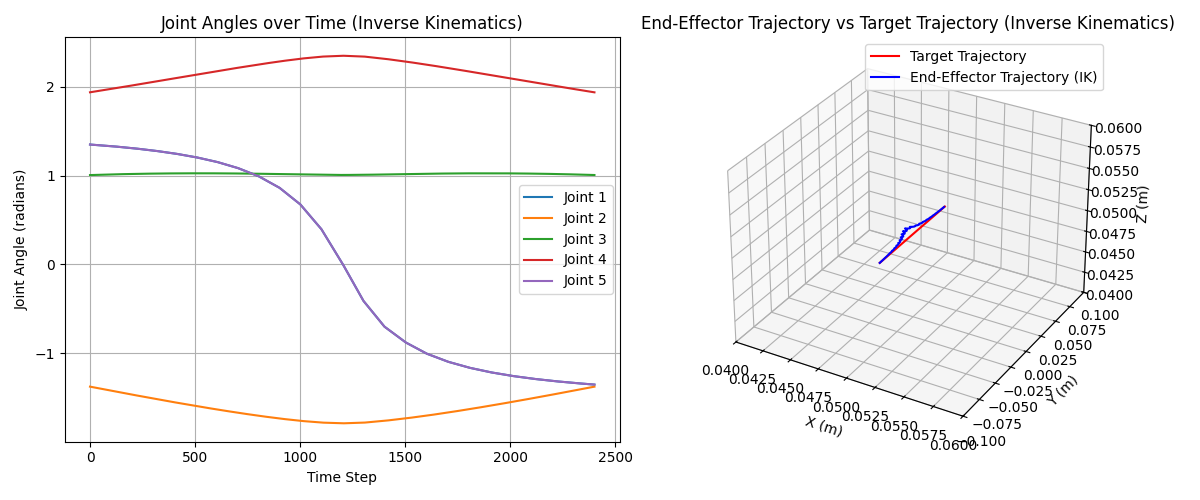

In [ ]:
plot_trajectories(joint_space_path_rrcl, end_effector_path_rrcl, displacements, "Resolved Rates with Closed-Loop/FWD Kinematics Correction")

Error Comparison

2401
2401


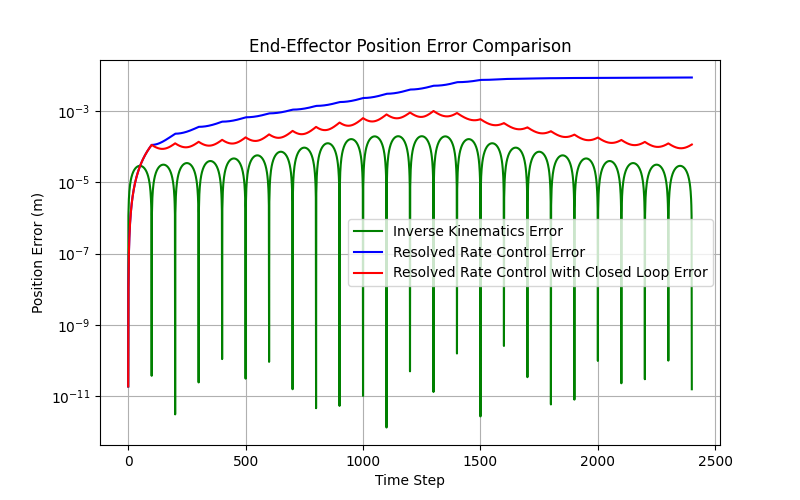

In [122]:
# Plot the closed loop position errors for the resolved rate control with closed loop correction
errors_rrcl = []
errors_rr = []
errors_ik = []
print(len(task_space_path_interpolated))
print(len(joint_space_path_rrcl))
for i in range(len(task_space_path_interpolated)):
    gwe_target = task_space_path_interpolated[i]
    pos_target = gwe_target[:3, 3]

    gwe_rrcl = so101.SO101._forward_kinematics(joint_space_path_rrcl[i])
    pos_rrcl = gwe_rrcl[:3, 3]
    error_rrcl = np.linalg.norm(pos_target - pos_rrcl)
    errors_rrcl.append(error_rrcl)
    
    gwe_rr = so101.SO101._forward_kinematics(joint_space_path_rr[i])
    pos_rr = gwe_rr[:3, 3]
    error_rr = np.linalg.norm(pos_target - pos_rr)
    errors_rr.append(error_rr)
    
    gwe_ik = so101.SO101._forward_kinematics(joint_space_path_ik[i])
    pos_ik = gwe_ik[:3, 3]
    error_ik = np.linalg.norm(pos_target - pos_ik)
    errors_ik.append(error_ik)

# Plotting the errors
plt.figure(figsize=(8, 5))
plt.plot(errors_ik, label='Inverse Kinematics Error', color='g')
plt.plot(errors_rr, label='Resolved Rate Control Error', color='b')
plt.plot(errors_rrcl, label='Resolved Rate Control with Closed Loop Error', color='r')
plt.yscale('log')
plt.title('End-Effector Position Error Comparison')
plt.xlabel('Time Step')
plt.ylabel('Position Error (m)')
plt.legend()
plt.grid(True)
plt.show()